In [139]:
# Để quản lý dữ liệu trong dataframe
import pandas as pd

# Để vẽ các loại biểu đồ
import matplotlib.pyplot as plt

In [140]:
# Sử dụng XGBoost cho bài toán hồi quy
from xgboost import XGBRegressor

# Sử dụng thư viện LabelEncoder để chuyển đổi biến phân loại thành dạng số
from sklearn.preprocessing import LabelEncoder

# Import các hàm và lớp cần thiết cho việc chia dữ liệu và tìm siêu tham số
from sklearn.model_selection import (KFold,
                                     train_test_split,
                                     RandomizedSearchCV)

# Import các độ đo đánh giá mô hình hồi quy
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             r2_score)

# 1.&nbsp;Đọc dữ liệu

In [141]:
# Đặt đường dẫn tới tệp CSV chứa dữ liệu đã được làm sạch
dataset_path = "../data/CarPricePrediction_Clean.csv"

# Đọc tệp CSV vào DataFrame
df = pd.read_csv(dataset_path)

In [142]:
# Hiển thị vài dòng đầu tiên của DataFrame để xem nhanh về dữ liệu
df.head()

,Màu sắc,Phân loại người bán,Tỉnh,Hãng,Dòng xe,Năm sản xuất,Số Km đã đi,Tình trạng,Hộp số,Nhiên liệu,Kiểu dáng,Số chỗ,Xuất xứ,Đối tác,Giá
0,đen,Bán chuyên,Hà Nội,Mitsubishi,Xpander,2022,50000,Đã sử dụng,Tự động,Xăng,Minivan (MPV),7,Đang cập nhật,No,559000000
1,nâu,Cá nhân,Tp Hồ Chí Minh,Nissan,Sunny,2019,52000,Đã sử dụng,Tự động,Xăng,Sedan,5,Hàn Quốc,No,335000000
2,đen,Cá nhân,Tp Hồ Chí Minh,Ford,Escape,2003,50000,Đã sử dụng,Tự động,Xăng,SUV / Cross over,5,Việt Nam,No,106000000
3,đen,Cá nhân,Tp Hồ Chí Minh,Hyundai,Accent,2021,42,Đã sử dụng,Tự động,Xăng,Sedan,4,Hàn Quốc,No,450000000
4,đỏ,Bán chuyên,Hà Nội,Ford,Ranger,2022,51000,Đã sử dụng,Tự động,Dầu,SUV / Cross over,5,Việt Nam,No,534000000


# 2.&nbsp;Label Encoding

In [143]:
# Lấy danh sách các cột có kiểu dữ liệu là object (có thể là biến phân loại)
categorical_columns = df.select_dtypes(include=['object']).columns

# Áp dụng Label Encoding cho từng cột phân loại
label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

# 3.&nbsp;Train - Test Split

In [144]:
# Chia tập dữ liệu thành đặc trưng đầu vào và đầu ra
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# In kích thước
print(f"Kích thước X: {X.shape}")
print(f"Kích thước y: {y.shape}")

Kích thước X: (2685, 14)
Kích thước y: (2685,)


In [145]:
# Phân chia dữ liệu thành tập huấn luyện và tập kiểm thử với tỷ lệ kiểm thử là 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# In kích thước tập huấn luyện
print(f"Kích thước X_train: {X_train.shape}")
print(f"Kích thước y_train: {y_train.shape}\n")

# In kích thước tập kiểm thử
print(f"Kích thước X_test: {X_test.shape}")
print(f"Kích thước y_test: {y_test.shape}")

Kích thước X_train: (2148, 14)
Kích thước y_train: (2148,)

Kích thước X_test: (537, 14)
Kích thước y_test: (537,)


# 4.&nbsp;Chạy mô hình với tham số mặc định

In [146]:
# Tạo một XGBRegressor với các tham số mặc định
xgb_res = XGBRegressor()

# Xem các tham số mặc định
default_params = xgb_res.get_params()

# Chọn ra các tham số mà bạn quan tâm
desired_params = ['n_estimators', 'learning_rate', 'max_depth', 'gamma', 'colsample_bytree', 'reg_alpha', 'reg_lambda']

# Lọc các tham số mà bạn quan tâm từ tham số mặc định
selected_default_params = {param: default_params[param] for param in desired_params}

# Tạo DataFrame từ các tham số mà bạn quan tâm
default_params_df = pd.DataFrame([selected_default_params])

# Đảo ngược vị trí giữa tên tham số và giá trị
default_params_df = default_params_df.transpose()

# Đặt tên cột cho DataFrame
default_params_df.columns = ['Value']

# In ra DataFrame với tên tham số ở các dòng
print("Các tham số mặc định của XGBRegressor:")
default_params_df

Các tham số mặc định của XGBRegressor:


,Value
n_estimators,100
learning_rate,None
max_depth,None
gamma,None
colsample_bytree,None
reg_alpha,None
reg_lambda,None


In [147]:
# Tạo một XGBRegressor với các tham số mặc định
xgb_res = XGBRegressor()

# Huấn luyện XGBRegressor trên dữ liệu huấn luyện
# và đưa ra dự đoán trên dữ liệu kiểm thử
xgb_res.fit(X_train, y_train)
y_pred = xgb_res.predict(X_test)

# In các độ đo đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R-squared (R2) Score: {r2:.3f}")

Mean Squared Error (MSE): 124425291114822368.000
Mean Absolute Error (MAE): 140300355.297
R-squared (R2) Score: 0.599


# 5.&nbsp;Fine - Tuning

In [148]:
# Lấy các tham số cần được điều chỉnh
params = {
    # "n_estimators": Số lần lặp của quá trình boosting.
    "n_estimators": range(100, 500, 50),

    # "learning_rate": Tỉ lệ học, giảm trọng số để làm cho quá trình boosting thêm thận trọng.
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],

    # "max_depth": Độ sâu tối đa của cây, ảnh hưởng đến độ phức tạp của mô hình.
    "max_depth": range(3, 21, 3),

    # "gamma": Điều chỉnh mức giảm tổn thất tối thiểu để thực hiện một phân chia.
    "gamma": [i / 10.0 for i in range(0, 5)],

    # "colsample_bytree": Phần trăm cột được lấy mẫu ngẫu nhiên cho mỗi cây.
    "colsample_bytree": [i / 10.0 for i in range(3, 10)],

    # "reg_alpha": Chế độ chính quy L1, giảm overfitting và làm mô hình thêm thận trọng.
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],

    # "reg_lambda": Chế độ chính quy L2, giảm overfitting và làm mô hình thêm thận trọng.
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]
}

# Tạo và huấn luyện mô hình tinh chỉnh cho XGBoost Regressor
rs = RandomizedSearchCV(XGBRegressor(),
                        params,
                        n_iter=50,
                        verbose=3,
                        random_state=42)
rs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[CV 1/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-1.013 total time=   0.9s
[CV 2/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-0.352 total time=   0.9s
[CV 3/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-0.790 total time=   0.9s
[CV 4/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-0.640 total time=   1.3s
[CV 5/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-0.986 total time=   0.8s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=1, max_depth=18, n_estimators=450, reg_alpha=1, reg_lambda=100;, score=0.665 total time=   1.6s
[CV 2/5] END colsample_bytree

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          predictor=None, random_state=None, ...),
                   n_iter=50,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.6,
                                                             0.7, 0.8, 0.9],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1],
                                        'max_depth': range(3, 21, 3),
                                        'n_estimators': range(100, 500, 50),
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 10,
                                                      100],
                                        'reg_lambda': [1e-05, 0.01, 0.1, 1, 10,
                                                       100]},
                   random_state=42, verbose=3)

In [149]:
# In điểm số tốt nhất và các tham số tốt nhất
# khi Random Search với các tham số trên
print(f'Điểm số tốt nhất: {rs.best_score_:.3f}')

# Tạo DataFrame từ các tham số tốt nhất
best_params_df = pd.DataFrame([rs.best_params_]).transpose()

# Đặt tên cột cho DataFrame
best_params_df.columns = ['Value']

# In ra DataFrame với tên tham số ở các dòng
print('Các tham số tốt nhất:')
best_params_df

Điểm số tốt nhất: 0.580
Các tham số tốt nhất:


,Value
reg_lambda,1.0
reg_alpha,0.1
n_estimators,300.0
max_depth,6.0
learning_rate,0.1
gamma,0.3
colsample_bytree,0.3


In [150]:
# Trích xuất thông tin kết quả Random Search và chuyển đổi thành DataFrame
results_df = pd.DataFrame(rs.cv_results_)

# Lựa chọn các cột quan trọng cho phân tích
selected_columns = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
results_df = results_df[selected_columns]

# Sắp xếp DataFrame dựa trên rank_test_score theo thứ tự tăng dần
results_df = results_df.sort_values(by='rank_test_score')

# Lưu DataFrame đã lựa chọn vào một tệp CSV
results_df.to_csv('../fine-tuning/RandomSearch_CV_XGBoost', index=False)

# 7.&nbsp;Đánh giá mô hình với tham số tốt nhất

## 7.1.&nbsp;Train - Test Split

In [151]:
# Tạo một XGBRegressor với các tham số tốt nhất
xgb_best = XGBRegressor(**rs.best_params_)

# Huấn luyện XGBRegressor trên dữ liệu huấn luyện
# và đưa ra dự đoán trên dữ liệu kiểm thử
xgb_best.fit(X_train, y_train)
y_pred = xgb_best.predict(X_test)

# In các độ đo đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R-squared (R2) Score: {r2:.3f}")

Mean Squared Error (MSE): 94516288892324848.000
Mean Absolute Error (MAE): 136751399.715
R-squared (R2) Score: 0.696


## 7.2.&nbsp;Cross Validation (K-Fold)

In [152]:
# Sử dụng KFold với 10 folds và hoán đổi dữ liệu trước mỗi lần chia
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Danh sách để lưu các giá trị MSE, MAE và R2 cho từng fold
mses = []
maes = []
r2s = []

# Vòng lặp qua các fold
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i + 1}:")  # Đánh số fold từ 1 để hiển thị

    # Huấn luyện mô hình trên tập huấn luyện của fold hiện tại
    xgb_best.fit(X[train_index], y[train_index])

    # Dự đoán trên tập kiểm tra của fold hiện tại
    y_pred = xgb_best.predict(X[test_index])

    # Tính toán các độ đo
    mse = mean_squared_error(y[test_index], y_pred)
    mae = mean_absolute_error(y[test_index], y_pred)
    r2 = r2_score(y[test_index], y_pred)

    # In các độ đo cho fold hiện tại
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"R-squared (R2) Score: {r2:.3f}")

    print()  # Xuống dòng cho phần in thông tin của fold tiếp theo

    # Lưu các độ đo vào danh sách
    mses.append(mse)
    maes.append(mae)
    r2s.append(r2)

# Tính toán và in ra giá trị trung bình của các độ đo trên tất cả các fold
mean_mse = sum(mses) / len(mses)
mean_mae = sum(maes) / len(maes)
mean_r2 = sum(r2s) / len(r2s)

print(f"Mean MSEs: {mean_mse:.3f}")
print(f"Mean MAEs: {mean_mae:.3f}")
print(f"Mean R2s: {mean_r2:.3f}")

Fold 1:
Mean Squared Error (MSE): 123916264114984448.000
Mean Absolute Error (MAE): 147500713.602
R-squared (R2) Score: 0.674

Fold 2:
Mean Squared Error (MSE): 53976701574024200.000
Mean Absolute Error (MAE): 122263676.015
R-squared (R2) Score: 0.776

Fold 3:
Mean Squared Error (MSE): 98271659814720816.000
Mean Absolute Error (MAE): 162044177.703
R-squared (R2) Score: 0.746

Fold 4:
Mean Squared Error (MSE): 474952566074383104.000
Mean Absolute Error (MAE): 166898876.082
R-squared (R2) Score: 0.386

Fold 5:
Mean Squared Error (MSE): 859560870464950144.000
Mean Absolute Error (MAE): 182533615.829
R-squared (R2) Score: 0.220

Fold 6:
Mean Squared Error (MSE): 57727627317186392.000
Mean Absolute Error (MAE): 126578594.265
R-squared (R2) Score: 0.790

Fold 7:
Mean Squared Error (MSE): 105363110906474464.000
Mean Absolute Error (MAE): 140736938.493
R-squared (R2) Score: 0.791

Fold 8:
Mean Squared Error (MSE): 239600829491567904.000
Mean Absolute Error (MAE): 169987227.216
R-squared (R2) S

## 7.3.&nbsp;Visualization

In [153]:
def plot_metric_scores(metric_values, metric_name):
    """
    Vẽ biểu đồ cột cho các giá trị của một độ đo cụ thể.

    Parameters:
    - metric_values: Danh sách chứa giá trị của độ đo cho từng fold.
    - metric_name: Tên của độ đo (vd: 'MAE', 'MSE', 'R2').

    Returns:
    None.
    """
    
    # Tạo biểu đồ cột với metric_values
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(metric_values) + 1), metric_values, color='skyblue')
    
    # Đặt nhãn cho trục x và y
    plt.xlabel('Fold')
    plt.ylabel(f'Điểm {metric_name}')
    
    # Đặt tiêu đề cho biểu đồ
    plt.title(f'Điểm {metric_name} cho từng Fold')
    
    # Đặt các nhãn trục x là số fold
    plt.xticks(range(1, len(metric_values) + 1))
    
    # Hiển thị biểu đồ
    plt.show()

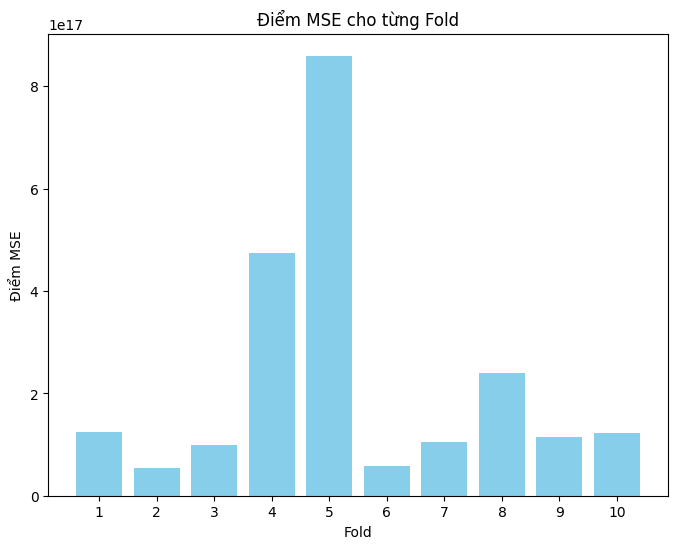

In [154]:
# Vẽ biểu đồ cho các giá trị MSE
plot_metric_scores(mses, "MSE")

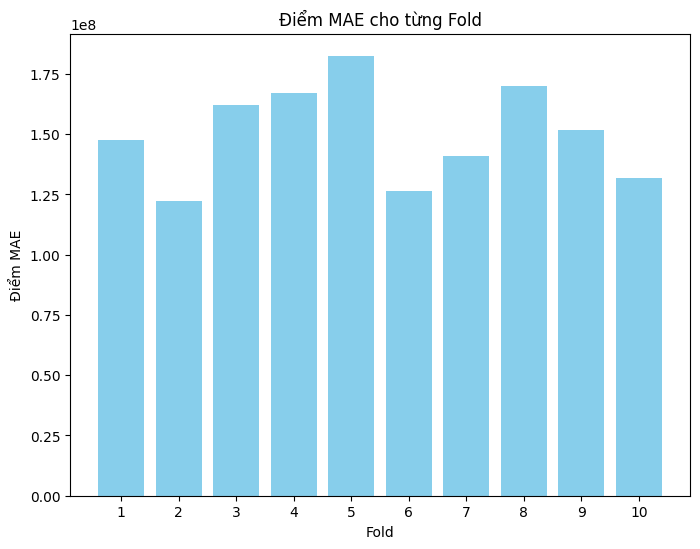

In [155]:
# Vẽ biểu đồ cho các giá trị MAE
plot_metric_scores(maes, "MAE")

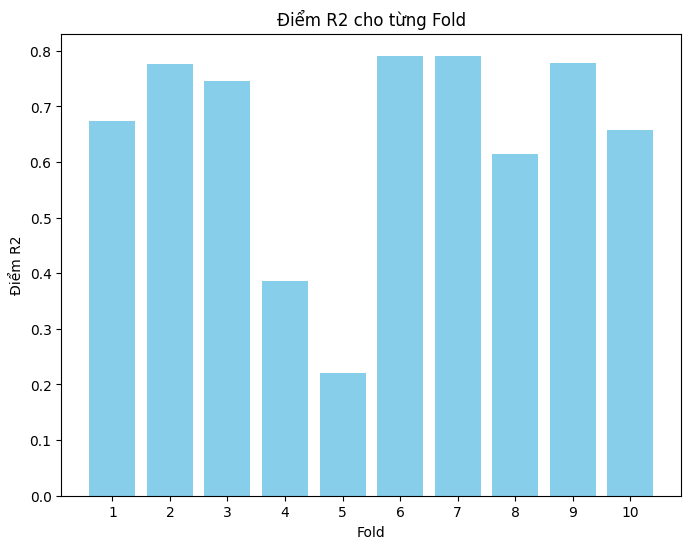

In [156]:
# Vẽ biểu đồ cho các giá trị R2
plot_metric_scores(r2s, "R2")